In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import scqubits
from functools import partial
import qutip
import concurrent
from loky import get_reusable_executor
import numpy as np
import qutip
import scqubits
from typing import List, Union,Any

from CoupledQuantumSystems.qobj_manip import *
from CoupledQuantumSystems.drive import *
from CoupledQuantumSystems.evo import ODEsolve_and_post_process
from CoupledQuantumSystems.noise import *
from CoupledQuantumSystems.qobj_manip import *
from CoupledQuantumSystems.IFQ import gfIFQ


In [6]:
from scipy.optimize import minimize

EJ = 4
EC = EJ/2.7
EL = EJ/45

qbt = gfIFQ(EJ = EJ,EC =EC,EL = EL,truncated_dim=20)

temp_in_mK = 20
loss_tangent_ref = 5e-6
one_over_f_flux_noise_amplitude = 1e-6

c_ops=qbt.get_T1_c_ops(temp_in_mK,
                        loss_tangent_ref,
                        one_over_f_flux_noise_amplitude)
e_ops = [qutip.ket2dm(qutip.basis(qbt.truncated_dim, i)) for i in range(12)]

from IPython.display import clear_output

t_duration = 50
tlist = np.linspace(0,t_duration,t_duration)
detuning = 0.2

 /tmp/ipykernel_701687/3362444143.py: 64

[0.8727789  0.84847549 0.1110832  0.10927272]


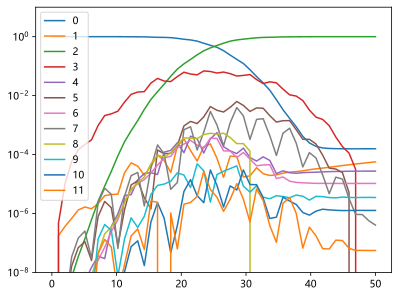

(3.503806685145605e-05, 0.00024596228729245606)


In [8]:
def objective(x):
    amp1_scaling_factor = x[0]
    amp2_scaling_factor = x[1]

    results  = qbt.run_qutip_mesolve_parrallel(
        initial_states = [qutip.basis(qbt.truncated_dim, 0),qutip.basis(qbt.truncated_dim, 2)],
        tlist = tlist,
        drive_terms = qbt.get_Raman_drive_terms(
            shape = 'gaussian',
            i = 0,
            j = 3,
            k = 2,
            detuning=detuning,
            t_duration=t_duration,
            amp1_scaling_factor = amp1_scaling_factor,
            amp2_scaling_factor = amp2_scaling_factor,
        ),
        c_ops = c_ops,
        e_ops = e_ops
    )
    clear_output()
    print(x)
    for i, exp in enumerate(results[0].expect):
        plt.plot(tlist,exp,label= f"{i}")
    plt.legend()
    plt.yscale('log')
    plt.ylim(1e-8,1e1)
    plt.show()
    
    one_minus_pop2 = np.abs( 1- (results[0].expect[2][-1] + 0.98* results[0].expect[1][-1]))
    one_minus_pop0 = np.abs(1- (results[1].expect[0][-1] +  0.98* results[1].expect[1][-1]))
    print((one_minus_pop2, one_minus_pop0))
    return one_minus_pop2 + one_minus_pop0

initial_guess = [0.8727789 , 0.84847549 ]

result = minimize(objective, initial_guess, method='Nelder-Mead')


# 4 sigma

In [2]:
def gaussian_pulse(t, args={}):
    w_d = args['w_d']
    amp = args['amp']
    t_duration = args['t_duration']
    t_start = args.get('t_start', 0)  # Default start time is 0
    how_many_sigma = args.get('how_many_sigma', 6)  # Default factor to determine sigma
    normalize = args.get('normalize', False)  # Default normalization is False
    phi = args.get('phi', 0)
    sigma = t_duration/how_many_sigma
    t_center = t_start + t_duration / 2  # Center of the Gaussian pulse

    def gaussian(t):
        return amp * np.exp(-((t - t_center) ** 2) / (2 * sigma ** 2))
    def cos_modulation():
        return 2 * np.pi * np.cos(w_d * 2 * np.pi * t - phi)
    t_end = t_start + t_duration  # End of the pulse

    if t < t_start or t > t_end:
        return 0
    else:
        pulse_value = gaussian(t)
        if normalize:
            a = gaussian(t_start)
            pulse_value = (pulse_value - a) / (1 - a)
        return pulse_value* cos_modulation() 
    
class gfIFQ:
    def __init__(self,
                 EJ,
                 EC,
                 EL,
                 flux=0, truncated_dim=20) -> None:
        self.fluxonium = scqubits.Fluxonium(EJ=EJ,
                                            EC=EC,
                                            EL=EL,
                                            flux=flux, cutoff=110,
                                            truncated_dim=truncated_dim)
        self.truncated_dim = truncated_dim
        self.evals = self.fluxonium.eigenvals(evals_count=truncated_dim)
        self.diag_hamiltonian = qutip.Qobj(2 * np.pi * np.diag(self.evals))
        self.phi_tabel = self.fluxonium.matrixelement_table(
            'phi_operator', evals_count=truncated_dim)
        self.n_tabel = self.fluxonium.matrixelement_table(
            'n_operator', evals_count=truncated_dim)

    def get_T1_c_ops(self,
                  temp_in_mK,
                  loss_tangent_ref,
                  one_over_f_flux_noise_amplitude) -> None:
        # array element [i,j] means transition rate from j to i
        dielectric_T1_array = np.full(
            (self.truncated_dim, self.truncated_dim), np.inf)
        one_over_f_T1_array = np.full(
            (self.truncated_dim, self.truncated_dim), np.inf)
        EL = self.fluxonium.EL
        EC = self.fluxonium.EC
        # T1
        for i in range(self.truncated_dim):
            for j in range(self.truncated_dim):
                if i == j:
                    continue
                freq = (self.evals[i]-self.evals[j]) * 2 * np.pi
                phi_ele = self.phi_tabel[i, j]
                dielectric_T1_array[j, i] = 1 / (np.abs(phi_ele)**2 * diel_spectral_density(
                    freq, EC, temp_in_mK, loss_tangent_ref))
                one_over_f_T1_array[j, i] = 1 / (np.abs(phi_ele)**2 * one_over_f_spectral_density(
                    freq, EL, one_over_f_flux_noise_amplitude))
        with np.errstate(divide='ignore', invalid='ignore'):
            T1_array = 1/(1/dielectric_T1_array + 1/one_over_f_T1_array)
        c_ops = qutip.Qobj(1/np.sqrt(T1_array))
        return c_ops

    def get_Tphi_c_ops(self,
                  one_over_f_flux_noise_amplitude) -> None:
        Tphi_array = np.zeros(shape=(self.truncated_dim,))
        # Tphi
        for ql in range(1,self.truncated_dim):
            Tphi_array[ql] = T_phi(
                second_order_derivative=second_order_derivative(partial(
                    get_frequency,
                    EJ=self.fluxonium.EJ,
                    EC=self.fluxonium.EC,
                    EL=self.fluxonium.EL,
                    i=0,j=ql
                    ),x0=0),
                one_over_f_flux_noise_amplitude=one_over_f_flux_noise_amplitude
            )
        c_ops = qutip.Qobj(np.diag(1/np.sqrt((Tphi_array))))
        return c_ops

    def get_Raman_drive_terms(self,
                              i,
                              j,
                              k,
                              detuning,
                              t_duration,
                              shape:str,
                              amp_scaling_factor = 1,
                              amp1_scaling_factor = 1,
                              amp2_scaling_factor = 1,
                              ):
        if shape == 'sin^2':
            pass
        elif shape == 'gaussian':
            how_many_sigma = 4
            sigma = t_duration/how_many_sigma
            # area =  amp= 2*np.pi /t_duration
            amp_ij = amp_scaling_factor*amp1_scaling_factor * np.sqrt(np.pi)/np.sqrt(2) / sigma / np.abs(self.n_tabel[i, j])
            amp_jk = amp_scaling_factor*amp2_scaling_factor* np.sqrt(np.pi)/np.sqrt(2) / sigma / np.abs(self.n_tabel[j, k])
            drive_terms = [
                DriveTerm(
                    driven_op=qutip.Qobj(
                        self.fluxonium.n_operator(energy_esys=True)),
                    pulse_shape_func=gaussian_pulse,
                    pulse_id='ij',
                    pulse_shape_args={
                        'w_d': np.abs(self.evals[j]-self.evals[i])-detuning,  # Without 2pi
                        'amp': amp_ij,  # Without 2pi
                        't_duration': t_duration,
                        'how_many_sigma': how_many_sigma,
                        'normalize':True,
                    },
                ),
                DriveTerm(
                    driven_op=qutip.Qobj(
                        self.fluxonium.n_operator(energy_esys=True)),
                    pulse_shape_func=gaussian_pulse,
                    pulse_id='jk',
                    pulse_shape_args={
                        'w_d': np.abs(self.evals[k]-self.evals[j])-detuning,  # Without 2pi
                        'amp': amp_jk,  # Without 2pi
                        't_duration': t_duration,
                        'how_many_sigma': how_many_sigma,
                        'normalize':True,
                   },
                ),
            ]
            return drive_terms
    def run_qutip_mesolve_parrallel(self,
                                    initial_states: qutip.Qobj,
                                    tlist: np.array,
                                    drive_terms: List[DriveTerm],
                                    c_ops: Union[None,
                                                 List[qutip.Qobj]] = None,
                                    e_ops: Union[None,
                                                 List[qutip.Qobj]] = None,
                                    post_processing=None,  # Currently I have no post_processing written
                                    ) -> None:

        post_processing_funcs = []
        post_processing_args = []
        results = [None] * len(initial_states)
        with get_reusable_executor(max_workers=None, context='loky') as executor:
            futures = {executor.submit(ODEsolve_and_post_process,
                                       y0=initial_states[i],
                                       tlist=tlist,
                                       static_hamiltonian=self.diag_hamiltonian,
                                       drive_terms=drive_terms,
                                       c_ops=c_ops,
                                       e_ops=e_ops,
                                       post_processing_funcs=post_processing_funcs,
                                       post_processing_args=post_processing_args,
                                       ): i for i in range(len(initial_states))}

            for future in concurrent.futures.as_completed(futures):
                original_index = futures[future]
                results[original_index] = future.result()
        return results

In [3]:
from scipy.optimize import minimize

EJ = 4
EC = EJ/2.7
EL = EJ/45

qbt = gfIFQ(EJ = EJ,EC =EC,EL = EL,truncated_dim=20)

temp_in_mK = 20
loss_tangent_ref = 5e-6
one_over_f_flux_noise_amplitude = 1e-6

c_ops=qbt.get_T1_c_ops(temp_in_mK,
                        loss_tangent_ref,
                        one_over_f_flux_noise_amplitude)
e_ops = [qutip.ket2dm(qutip.basis(qbt.truncated_dim, i)) for i in range(12)]

from IPython.display import clear_output

t_duration = 30
tlist = np.linspace(0,t_duration,t_duration)
detuning = 0.2

 /tmp/ipykernel_724805/999016822.py: 64

[0.96266061 0.92304883]


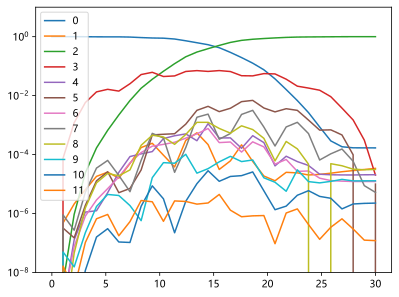

(0.0002845409191402082, 0.0003516208300339274)


In [4]:
def objective(x):
    amp1_scaling_factor = x[0]
    amp2_scaling_factor = x[1]

    results  = qbt.run_qutip_mesolve_parrallel(
        initial_states = [qutip.basis(qbt.truncated_dim, 0),qutip.basis(qbt.truncated_dim, 2)],
        tlist = tlist,
        drive_terms = qbt.get_Raman_drive_terms(
            shape = 'gaussian',
            i = 0,
            j = 3,
            k = 2,
            detuning=detuning,
            t_duration=t_duration,
            amp1_scaling_factor = amp1_scaling_factor,
            amp2_scaling_factor = amp2_scaling_factor,
        ),
        c_ops = c_ops,
        e_ops = e_ops
    )
    clear_output()
    print(x)
    for i, exp in enumerate(results[0].expect):
        plt.plot(tlist,exp,label= f"{i}")
    plt.legend()
    plt.yscale('log')
    plt.ylim(1e-8,1e1)
    plt.show()
    
    one_minus_pop2 = np.abs( 1- (results[0].expect[2][-1] + 0.98* results[0].expect[1][-1]))
    one_minus_pop0 = np.abs(1- (results[1].expect[0][-1] +  0.98* results[1].expect[1][-1]))
    print((one_minus_pop2, one_minus_pop0))
    return one_minus_pop2 + one_minus_pop0

initial_guess = [0.8727789 , 0.84847549 ]

result = minimize(objective, initial_guess, method='Nelder-Mead')
